<div>
<img src="https://csdms.colorado.edu/csdms_wiki/images/ESPIn-mtns-skinny-transparent.png" width="800"/>
</div>

<div>
<img src="https://csdms.colorado.edu/csdms_wiki/images/thumb/CSDMS-logo-color-notagline-ver_high.png/400px-CSDMS-logo-color-notagline-ver_high.png" width="200" hspace="20"><a href="http://landlab.github.io"><img src="https://raw.githubusercontent.com/landlab/tutorials/release/landlab_header.png" width="500"></a>
</div>

# Post-Glacial Landscape Lab: What happens in a still-icy landscape once the glaciers are gone? 
ESPIn 2025 project exploring landscape influence of glacial retreat on near term landscapes and watersheds.

#### Team Members
* Viet M Bui (organic rice fed - Delta & SLR dude)
* Ari Koeppel (sol3ling)
* Shayla Triantafillou (river gal)
* Karin Lehnigk (glof club)
* Lucille Baker-Stahl (temperature + morphodynamics = ?)
* Tom Hoseason (tbd)

# Table of Contents
* [Introduction to post-glacial landscape modification](#Intro)
* [Simple ice-cored moraine diffusion](#Moraine)
* [Simple post glacial fluvial plain](#Plain)
* [Linking together components to track a postglacial surface system](#Linking)
* [Summary and implications for our warming Arctic and alpine](#Summary)


## Intro

## Moraine

Glacier Surface Hydrology is the key role to understand and study the meltwater dynamics of when and how water flows across glaciers and ice sheets. This lab notebook is desgined for undergraduates and graduate students to learn how meltwater flows across different types of glaciers in the world. Users will explore how water will flow on a synthetic glacier with varying surface topography and a mountain glacier through tools from Landlab and other glaciological concepts.

## Plain

## Summary

In [2]:
from landlab.components import (
    FlowDirectorD8,
    FlowDirectorMFD,
    FlowDirectorSteepest,
    FlowAccumulator, 
    SinkFillerBarnes,
    DepressionFinderAndRouter
)

from bmi_topography import Topography
from landlab import RasterModelGrid
from landlab.plot.drainage_plot import drainage_plot
from landlab.plot.graph import plot_graph
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

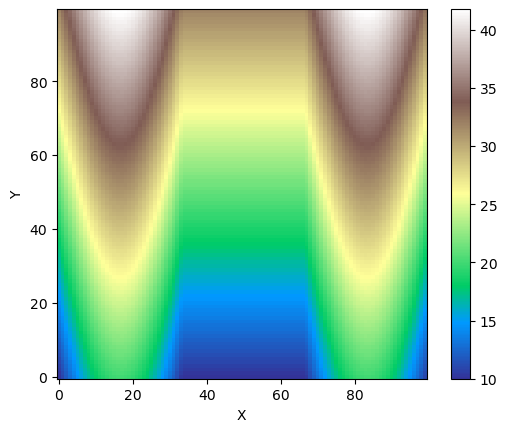

In [6]:
#define the grid
size_x = 100
size_y = 100
spacing = 1.0
grid = RasterModelGrid((size_x, size_y), xy_spacing=spacing)

# morph the grid with a sine function
moraine_height = 10
bedrock_slope = 0.22
layer_thickness = 10

grid.add_zeros('topographic__elevation', at='node')
x = grid.x_of_node
y = grid.y_of_node
z = moraine_height * np.sin(np.pi*x / (size_x/3))
z[z<0] = 0
z += bedrock_slope*y + layer_thickness
grid.at_node['topographic__elevation'] = z

# show grid
grid.imshow('topographic__elevation', cmap=cm.terrain)

Classroom organization
In this lab, you will learn how to use Topography and ERA5 Data Components to download terrain and precipitation datasets. You will also learn how to use the Landlab components (FlowAccumulator, ChannelProfiler, OverlandFlow) and the Landlab utility (get_watershed_mask) for watershed delineation and overland flow simulation.

Learning objectives
Skills

    Learn to use Data Components to download research datasets.
    Learn to couple Data and Model Components for overland flow simulation.

Key concepts

    Landlab
    Data-Model Integration
    CSDMS Data Component


Lab notes
This lab can be run on the lab (for educators) and jupyter (for general use) instances of the OpenEarthscape JupyterHub: just click one of the links under the Run online using heading at the top of this page, then run the notebook in the "CSDMS" kernel.


If you don't already have a JupyterHub account, follow the instructions to sign up at https://csdms.colorado.edu/wiki/JupyterHub. If you're an educator, you can get JupyterHub accounts for students--please contact us through the CSDMS Help Desk: https://csdms.github.io/help-desk.

Requirements
If run locally, please follow the instruction at https://github.com/gantian127/overlandflow_usecase.

Acknowledgements
This work was supported by the National Science Foundation under collaborative grants 1831623, 2026951, 2140831, 2104102, and 2148762.

References

    Barnhart, K. R., Hutton, E. W. H., Tucker, G. E., M. Gasparini, N., Istanbulluoglu, E., E. J. Hobley, D., J. Lyons, N., Mouchene, M., Siddhartha Nudurupati, S., M. Adams, J., & Bandaragoda, C. (2020). Short communication: Landlab v2.0: A software package for Earth surface dynamics. Earth Surface Dynamics, 8(2), 379–397. https://doi.org/10.5194/esurf-8-379-2020